In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("nameses/girl_names.txt", "r").read().splitlines()
words = [word.lower() for word in words]
words[:8]

['abel', 'abelone', 'abigael', 'abigail', 'ada', 'adela', 'adelaide', 'adele']

In [3]:
len(words)

3046

In [4]:
# Building out vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ä', 28: 'å', 29: 'æ', 30: 'ç', 31: 'é', 32: 'ø', 0: '.'}
33


In [5]:
# Buliding the dataset with splits
block_size = 8 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

torch.Size([17019, 8]) torch.Size([17019])
torch.Size([2145, 8]) torch.Size([2145])
torch.Size([2065, 8]) torch.Size([2065])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> a
.......a --> l
......al --> l
.....all --> i
....alli --> .
........ --> g
.......g --> ø
......gø --> n
.....gøn --> n
....gønn --> e
...gønne --> r
..gønner --> .
........ --> n
.......n --> o
......no --> r
.....nor --> v
....norv --> e
...norve --> i
..norvei --> g
.norveig --> .


## Main code

In [7]:
# OOP is OP
# -----------------------------------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------------------------------
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((vocab_size, n_embd))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # Get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    

In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [27]:
n_embd = 24 # the dimensionality of the character embedding  vectors
n_hidden= 128 # number of neurons in the hidden layer

model  = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print("Total parameters:" ,sum(p.nelement() for p in parameters)) # number of total trainable parameters
for p in parameters:
    p.requires_grad = True

Total parameters: 77497


**Here is essentially what our new model looks like:**

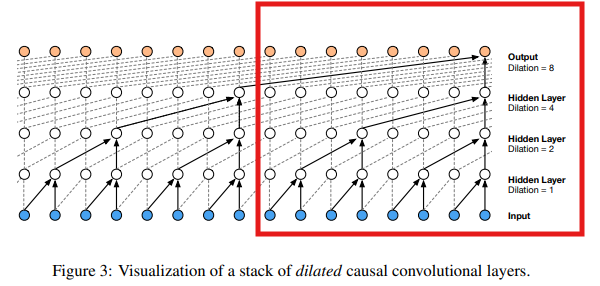

### Testing for new flatten layer

In [24]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  4,  5, 12,  9, 14,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 19,  5, 18,  9]])

In [25]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 33)


In [26]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [195]:
model.layers[0].out.shape # output of Embedding Layer

torch.Size([4, 8, 10])

In [196]:
model.layers[1].out.shape # output of Flatten Layer

torch.Size([4, 80])

In [197]:
model.layers[2].out.shape # output of Linear Layer

torch.Size([4, 200])

In [198]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [199]:
# (1 2) (3 4) (5 6) (7 8) --> group each pair of input characters into bigrams


torch.randn(4, 8, 10).view(4,4,20).shape

torch.Size([4, 4, 20])

In [200]:
list(range(10)[1::2])

[1, 3, 5, 7, 9]

In [201]:
e = torch.randn(4, 8, 10) # goal: we want this to be (4, 4, 20) where consectuive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [202]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [203]:
torch.allclose(e.view(4,4,20), explicit)

True

In [204]:
n = 1
B, T, C = e.shape

print(f"B: {B},  T: {T} C: {C}")
print(f"B_new: {B}, T_new: {T//n}, C_new: {C*n}")

B: 4,  T: 8 C: 10
B_new: 4, T_new: 8, C_new: 10


In [211]:
mod = Sequential([FlattenConsecutive(8)])

print(e.shape)
z = mod(e)
print(z.shape)

torch.Size([4, 8, 10])
torch.Size([4, 80])


### Training loop

In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass
    logits = model(Xb)  
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update: simple SGD
    lr = 10**-1 if i < 150000 else 100**-1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # if i % 1000 == 0:
    #     break

      0/ 200000: 3.5067
  10000/ 200000: 1.0498
  20000/ 200000: 1.4374
  30000/ 200000: 1.2118
  40000/ 200000: 1.0207
  50000/ 200000: 1.6218
  60000/ 200000: 1.0789
  70000/ 200000: 1.3740
  80000/ 200000: 1.4373
  90000/ 200000: 1.1631
 100000/ 200000: 1.0353
 110000/ 200000: 1.0415
 120000/ 200000: 0.9800
 130000/ 200000: 0.9925
 140000/ 200000: 1.2923
 150000/ 200000: 1.0685
 160000/ 200000: 0.9735
 170000/ 200000: 1.3277
 180000/ 200000: 0.9041
 190000/ 200000: 1.0761


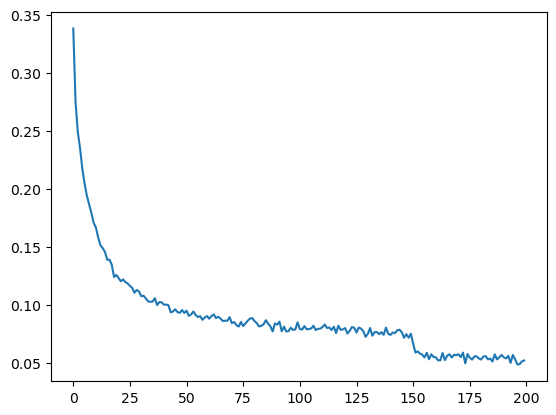

In [29]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
plt.show()

In [30]:
# put layers into eval-mode
for layer in model.layers:
    layer.training = False

In [31]:
for layer in model.layers:
    if not isinstance(layer, Embedding):
        print(f"LAYER: {layer.__class__.__name__}, TRAINABLE: {layer.training if hasattr(layer, 'training') else 'N/A'}")


LAYER: FlattenConsecutive, TRAINABLE: False
LAYER: Linear, TRAINABLE: False
LAYER: BatchNorm1d, TRAINABLE: False
LAYER: Tanh, TRAINABLE: False
LAYER: FlattenConsecutive, TRAINABLE: False
LAYER: Linear, TRAINABLE: False
LAYER: BatchNorm1d, TRAINABLE: False
LAYER: Tanh, TRAINABLE: False
LAYER: FlattenConsecutive, TRAINABLE: False
LAYER: Linear, TRAINABLE: False
LAYER: BatchNorm1d, TRAINABLE: False
LAYER: Tanh, TRAINABLE: False
LAYER: Linear, TRAINABLE: False


In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.1313610076904297
val 2.3718950748443604


### Performance Log

**Standard MLP blcok size 8:** train: 1.3966, val: 2.1612

**Wavenet 22K parameters:** train 1.1641, val: 2.2088

**Wavenet 77K parameters:** train 1.1314, val: 2.3719

## Drawing sample names 

In [19]:

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item() 

        # shift the context window and track the samples
        context = context[1:] + [ix] 
        out.append(ix)
        
        # if samples special character "." -> break
        if ix == 0: 
            break
    print("".join(itos[i] for i in out))

sirpa.
gyrin.
adelhelen.
rebecka.
daniele.
renata.
juli.
sigbjørg.
davida.
mette.
vinnie.
borgunn.
mary.
gjertrude.
josie.
yolanda.
siana.
inghild.
signora.
suzan.


In [20]:
[name for name in words if "mili" in name]

['emilie', 'emilija', 'amilia', 'milica', 'emili', 'amilie', 'emilia']

### Next time:

Why convolutions? Brief preview/hint

In [21]:
for x,y in zip(Xtr[12:20], Ytr[12:20]):
    print("".join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> n
.......n --> o
......no --> r
.....nor --> v
....norv --> e
...norve --> i
..norvei --> g
.norveig --> .


In [22]:
# forward pass a single example:
logits = model(Xtr[[12]])
logits.shape

torch.Size([1, 33])

In [23]:
# forward all of them
logits = torch.zeros(8, 33)
for i in range(8):
    logits[i] = model(Xtr[[12 + i]])
logits.shape

torch.Size([8, 33])

In [ ]:
# Convolution is a "for loop" (in the CUDA kernel)
# allows us to forward Linear layers efficiently over space